In [3]:
import sys
sys.path.append("../")

# Look at PPI data

In [4]:
import torch
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader

# Load the PPI dataset
train_dataset = PPI(root='/tmp/PPI', split='train')
val_dataset = PPI(root='/tmp/PPI', split='val')
test_dataset = PPI(root='/tmp/PPI', split='test')


In [5]:
for train in train_dataset:
    print(train)

Data(x=[1767, 50], edge_index=[2, 32318], y=[1767, 121])
Data(x=[1377, 50], edge_index=[2, 29704], y=[1377, 121])
Data(x=[2263, 50], edge_index=[2, 59644], y=[2263, 121])
Data(x=[2339, 50], edge_index=[2, 65430], y=[2339, 121])
Data(x=[1578, 50], edge_index=[2, 36162], y=[1578, 121])
Data(x=[1021, 50], edge_index=[2, 18216], y=[1021, 121])
Data(x=[1823, 50], edge_index=[2, 44330], y=[1823, 121])
Data(x=[2488, 50], edge_index=[2, 70390], y=[2488, 121])
Data(x=[591, 50], edge_index=[2, 7708], y=[591, 121])
Data(x=[3312, 50], edge_index=[2, 106198], y=[3312, 121])
Data(x=[2401, 50], edge_index=[2, 64218], y=[2401, 121])
Data(x=[1878, 50], edge_index=[2, 46268], y=[1878, 121])
Data(x=[1819, 50], edge_index=[2, 45768], y=[1819, 121])
Data(x=[3480, 50], edge_index=[2, 106754], y=[3480, 121])
Data(x=[2794, 50], edge_index=[2, 85318], y=[2794, 121])
Data(x=[2326, 50], edge_index=[2, 59862], y=[2326, 121])
Data(x=[2650, 50], edge_index=[2, 77064], y=[2650, 121])
Data(x=[2815, 50], edge_index=[2

In [6]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

# Training

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
from scGraphLLM.config.model_config import GNNConfig
from scGraphLLM.train import TrainerConfig

In [9]:
gnn_config = GNNConfig()
gnn_config.input_dim = 50
gnn_config.hidden_dims = (128, 128, 128)
gnn_config.conv_dim = 64
gnn_config.out_dim = 121

In [14]:
train_config = TrainerConfig()
train_config.lr = 1e-2
train_config.num_epochs = 5
train_config.max_grad = 1000.0
train_config.weight_decay = 1e-4
train_config.alpha = 0.001
train_config.verbose = True
train_config.lambda_l1 = 0.01
train_config.lambda_l2 = 0.01

In [15]:
from scGraphLLM.train import GNN_Trainer

In [16]:
trainer = GNN_Trainer(train_loader, val_loader, gnn_config, train_config)

Number of Attention layers:  4
Number of GNN layers:  5
Number of Batch Normalization layers:  4


In [17]:
trainer.device

device(type='cpu')

In [18]:
model, A, H, Attn, loss_train, loss_val = trainer.train_loop()

100%|██████████| 1/1 [00:07<00:00,  7.28s/it]


[Epoch 0001]  Overall Loss: 1.37037
[Epoch 0001]  Overall val: 14.36146


100%|██████████| 1/1 [00:07<00:00,  7.41s/it]


[Epoch 0002]  Overall Loss: 0.51443
[Epoch 0002]  Overall val: 7.43024


100%|██████████| 1/1 [00:17<00:00, 17.23s/it]


[Epoch 0003]  Overall Loss: 0.29420
[Epoch 0003]  Overall val: 4.57815


100%|██████████| 1/1 [00:12<00:00, 12.51s/it]


[Epoch 0004]  Overall Loss: 0.19096
[Epoch 0004]  Overall val: 3.06554


  0%|          | 0/1 [00:00<?, ?it/s]

: 

In [13]:
import matplotlib.pyplot as plt
import numpy as np

In [1]:
plt.plot(np.clip(loss_train, None, loss_train[0]), label='loss train')
plt.plot(np.clip(loss_val, None, loss_val[0]), label='loss val')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

In [15]:
data_list = [val for val in val_dataset]
data_list

[Data(x=[3230, 50], edge_index=[2, 97446], y=[3230, 121]),
 Data(x=[3284, 50], edge_index=[2, 101474], y=[3284, 121])]

In [16]:
A_final = A[-1]

NameError: name 'A' is not defined

In [36]:
A_final

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<WhereBackward0>)

In [37]:
data_one_graph = data_list[0]
learned_graph = A_final[:3230, :3230]
learned_graph.shape

torch.Size([3230, 3230])

In [38]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx, dense_to_sparse

In [39]:
data_one_graph

Data(x=[3230, 50], edge_index=[2, 97446], y=[3230, 121])

/var/folders/n0/lbm2yq4n3r1gp83zkf5s69j00000gn/T/ipykernel_16842/1080113788.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


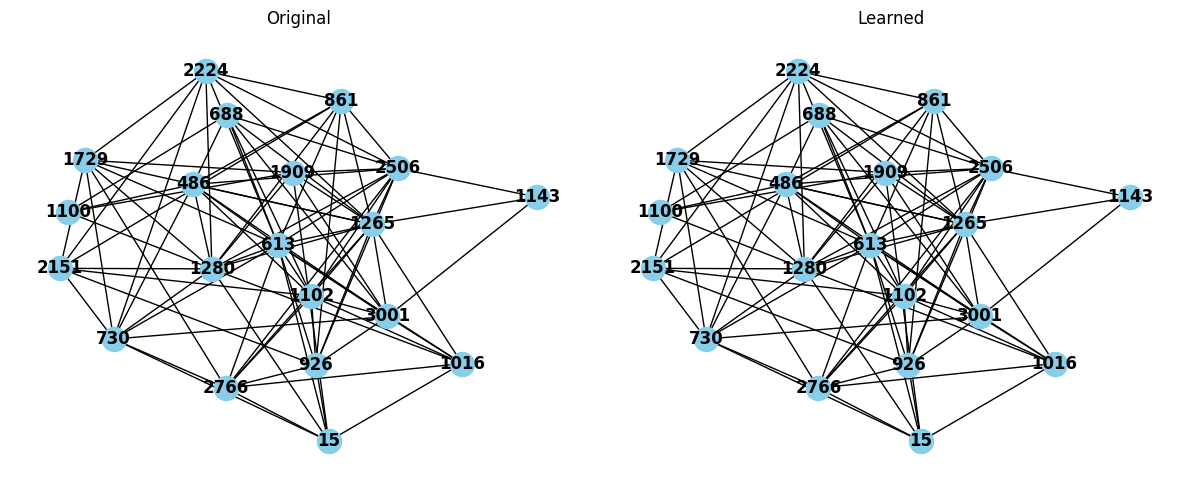

In [40]:
from matplotlib.colors import LinearSegmentedColormap
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes = axes.flatten()
cmap = plt.cm.get_cmap('viridis')

data = data_one_graph
G = to_networkx(data, to_undirected=True)
centrality = nx.degree_centrality(G)
top_nodes = sorted(centrality, key=centrality.get, reverse=True)[:20]
H = G.subgraph(top_nodes)
pos = nx.spring_layout(H, k=2)
nx.draw(H, ax=axes[0], pos=pos, with_labels=True, node_color='skyblue', node_size=300, font_weight='bold', width=1)
axes[0].set_title("Original")

learned, w_learned = dense_to_sparse(learned_graph)
edges = list(zip(learned[0].numpy(), learned[1].numpy()))
G2 = nx.Graph()
G2.add_edges_from(edges)
edge_weights = [w_learned[j].item() for j in range(w_learned.size(0))]

centrality = nx.degree_centrality(G2)
top_nodes = sorted(centrality, key=centrality.get, reverse=True)[:20]
H2 = G2.subgraph(top_nodes)

nx.draw(H2, pos=pos, ax=axes[1], with_labels=True, node_color='skyblue', node_size=300, 
        font_weight='bold', width=1)
axes[1].set_title("Learned")


# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [41]:
Attn[-1].shape

torch.Size([6514, 2, 2, 6514])